# Import Required Libraries & Setup Device

In [1]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.transforms import functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Error Handling
try:
    from torch.cuda.amp import autocast, GradScaler
except ImportError:
    from contextlib import contextmanager
    @contextmanager
    def autocast(enabled=True):
        yield
    class GradScaler:
        def scale(self, loss):
            return loss
        def unscale_(self, optimizer):
            pass
        def step(self, optimizer):
            optimizer.step()
        def update(self):
            pass

# Set Current Working Directory
from pathlib import Path
project_root = Path.cwd().parent

c:\Users\ANSUMAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# Dataset and DataLoader Setup
Define the UltrasoundSegmentationDataset class to load images and masks, apply specified transforms, and set up validation and test DataLoaders using random_split.

In [2]:
class UltrasoundSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_img=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return image, mask

transform_img = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])
transform_mask = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

# Update these paths as needed
images_dir = project_root / "Dataset" / "Images"
masks_dir = project_root / "Dataset" / "Masks"
dataset = UltrasoundSegmentationDataset(images_dir, masks_dir, transform_img=transform_img, transform_mask=transform_mask)

# Split dataset into validation and test (e.g., 50/50 split of non-training samples)
total_samples = len(dataset)
val_size = total_samples // 2
test_size = total_samples - val_size
val_dataset, test_dataset = random_split(dataset, [val_size, test_size])
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# U-Net Model Definition and Loading
Define the UNet model architecture using torch.nn modules, instantiate the model, set the device, and load the saved model weights.

In [3]:
# Define the U-Net model architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU()
        )
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
        
    def forward(self, x):
        e1 = self.enc_conv1(x)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        up2 = self.upconv2(b)
        cat2 = torch.cat([up2, e2], dim=1)
        d2 = self.dec_conv2(cat2)
        up1 = self.upconv1(d2)
        cat1 = torch.cat([up1, e1], dim=1)
        d1 = self.dec_conv1(cat1)
        out = self.final_conv(d1)
        out = torch.sigmoid(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model and load saved weights
model = UNet().to(device)
model.load_state_dict(torch.load(project_root / "Model Weights" / "hypothesis_best_model_weights.pth", map_location=device))
print("Loaded segmentation model weights.")

Using device: cpu
Loaded segmentation model weights.


# Define Evaluation Function
Create a function using torch.no_grad that evaluates the model on a given data loader using BCELoss and prints the average loss.

In [4]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    criterion = nn.BCELoss()  # Define the loss function
    total_loss = 0.0  # Initialize total loss

    with torch.no_grad():  # Disable gradient calculation
        for images, masks in data_loader:
            images = images.to(device)  # Move images to the device
            masks = masks.to(device)  # Move masks to the device
            preds = model(images)  # Get model predictions
            loss = criterion(preds, masks)  # Calculate loss
            total_loss += loss.item()  # Accumulate loss

    avg_loss = total_loss / len(data_loader)  # Calculate average loss
    print(f"Avg Loss: {avg_loss:.4f}")  # Print average loss
    return avg_loss  # Return average loss

# Run Evaluation on Validation and Test Sets
Call the evaluation function on both the validation and test DataLoaders to compute and print the average loss for each set.

In [5]:
# Evaluate the model on the validation set
print("----- Validation Set Evaluation -----")
evaluate_model(model, val_loader, device)

# Evaluate the model on the test set
print("\n----- Test Set Evaluation -----")
evaluate_model(model, test_loader, device)

----- Validation Set Evaluation -----
Avg Loss: 0.0343

----- Test Set Evaluation -----
Avg Loss: 0.0346


0.03457018317511448

# Post-Processing Functions for Biometry Extraction

In [6]:
import cv2
import numpy as np

def extract_biometry_points(segmentation_mask):
    """
    Given a segmentation mask (torch.Tensor with shape [1,H,W] and values in [0,1]),
    find the largest contour, fit an ellipse, and return four endpoints.
    """
    mask_np = segmentation_mask.squeeze().cpu().numpy()
    mask_bin = (mask_np * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    if len(largest) < 5:
        return None
    ellipse = cv2.fitEllipse(largest)
    (xc, yc), (d1, d2), angle = ellipse
    a, b = d1/2, d2/2
    rad = np.deg2rad(angle)
    p1 = (xc + a * np.cos(rad), yc + a * np.sin(rad))
    p2 = (xc - a * np.cos(rad), yc - a * np.sin(rad))
    p3 = (xc - b * np.sin(rad), yc + b * np.cos(rad))
    p4 = (xc + b * np.sin(rad), yc - b * np.cos(rad))
    return [p1, p2, p3, p4]

def extract_skull_diameters(segmentation_mask):
    pts = extract_biometry_points(segmentation_mask)
    if pts is None:
        return None, None, None
    import math
    d1 = math.hypot(pts[0][0] - pts[1][0], pts[0][1] - pts[1][1])
    d2 = math.hypot(pts[2][0] - pts[3][0], pts[2][1] - pts[3][1])
    if d1 <= d2:
        bpd = (pts[0], pts[1])
        ofd = (pts[2], pts[3])
    else:
        bpd = (pts[2], pts[3])
        ofd = (pts[0], pts[1])
    return bpd, ofd, pts

# Visualize Sample Predictions
Implement a visualization function that plots the original image, ground truth mask, and predicted mask using matplotlib, then run it on a sample from the test set.

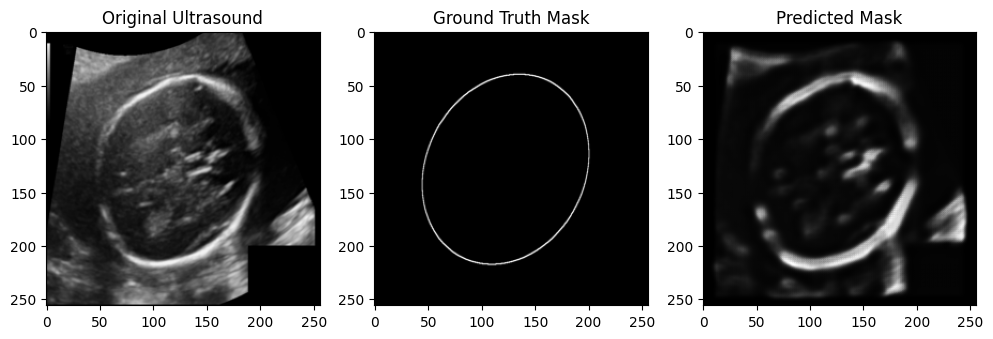

Extracted Ellipse Endpoints: [(100.8210976477366, 140.20378147654745), (121.94243689816184, 19.83535731739787), (23.664827645694103, 64.62766530901425), (199.09870690020432, 95.41147348493107)]
BPD Points (smaller diameter): ((100.8210976477366, 140.20378147654745), (121.94243689816184, 19.83535731739787))
OFD Points (larger diameter): ((23.664827645694103, 64.62766530901425), (199.09870690020432, 95.41147348493107))


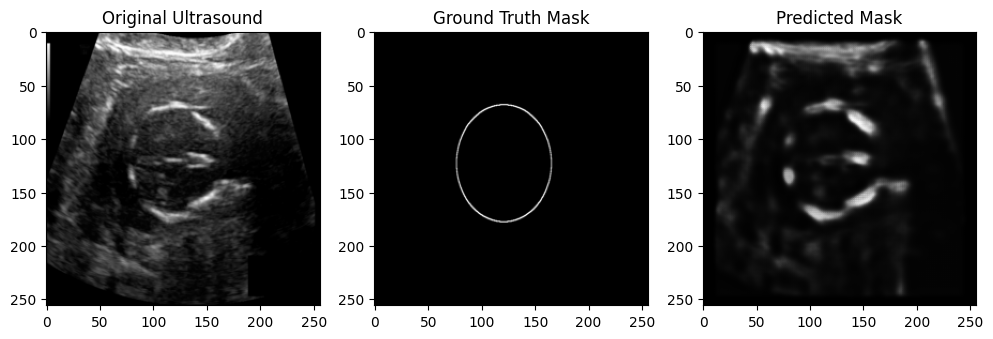

Extracted Ellipse Endpoints: [(196.25328092695213, 172.29490439195376), (42.445113848438496, 58.04335244398374), (50.31999284165963, 208.09789170469094), (188.378401933731, 22.24036513124655)]
BPD Points (smaller diameter): ((196.25328092695213, 172.29490439195376), (42.445113848438496, 58.04335244398374))
OFD Points (larger diameter): ((50.31999284165963, 208.09789170469094), (188.378401933731, 22.24036513124655))


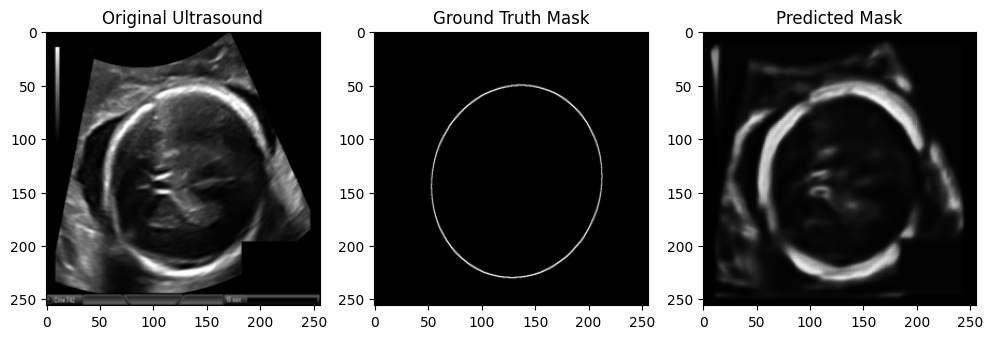

Extracted Ellipse Endpoints: [(206.60542536806219, 175.0179973101808), (27.75547551084408, 92.05661816833484), (70.99705555992125, 233.1004772993702), (163.363845318985, 33.97413817914541)]
BPD Points (smaller diameter): ((206.60542536806219, 175.0179973101808), (27.75547551084408, 92.05661816833484))
OFD Points (larger diameter): ((70.99705555992125, 233.1004772993702), (163.363845318985, 33.97413817914541))


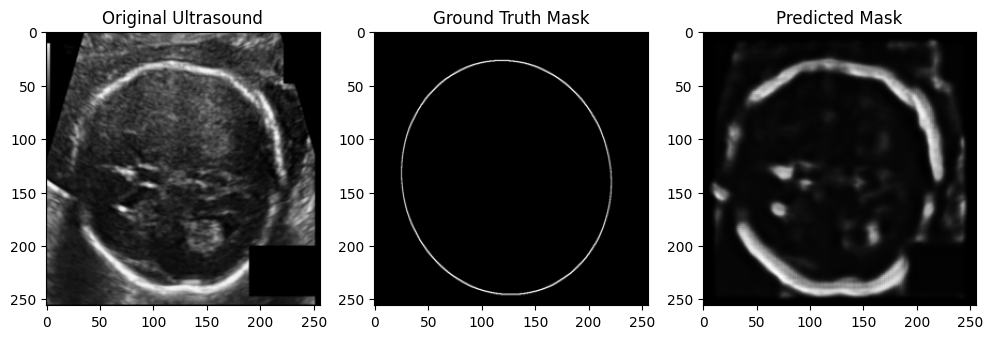

Extracted Ellipse Endpoints: [(21.711364663154498, 134.80087741978727), (221.8192444677049, 132.04790798060336), (120.28870424107092, 26.093248365466238), (123.24190488978846, 240.75553703492437)]
BPD Points (smaller diameter): ((21.711364663154498, 134.80087741978727), (221.8192444677049, 132.04790798060336))
OFD Points (larger diameter): ((120.28870424107092, 26.093248365466238), (123.24190488978846, 240.75553703492437))


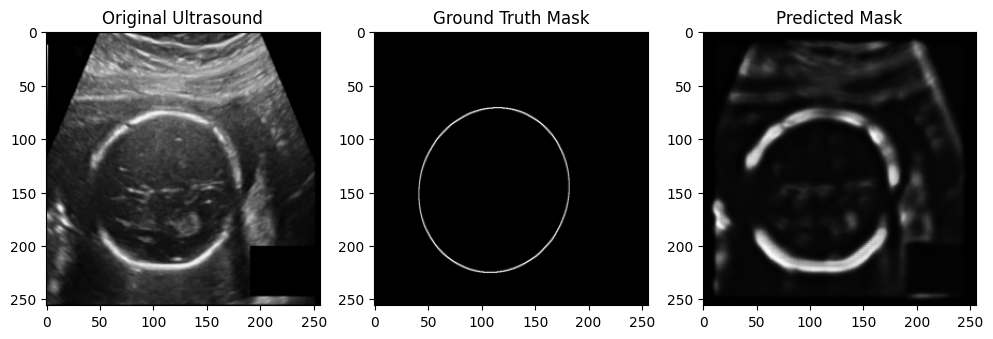

Extracted Ellipse Endpoints: [(89.69893696535385, 161.07156975471312), (177.32263896238052, 10.321679757005626), (43.03664504451085, 33.108332069724476), (223.9849308832235, 138.28491744199428)]
BPD Points (smaller diameter): ((89.69893696535385, 161.07156975471312), (177.32263896238052, 10.321679757005626))
OFD Points (larger diameter): ((43.03664504451085, 33.108332069724476), (223.9849308832235, 138.28491744199428))


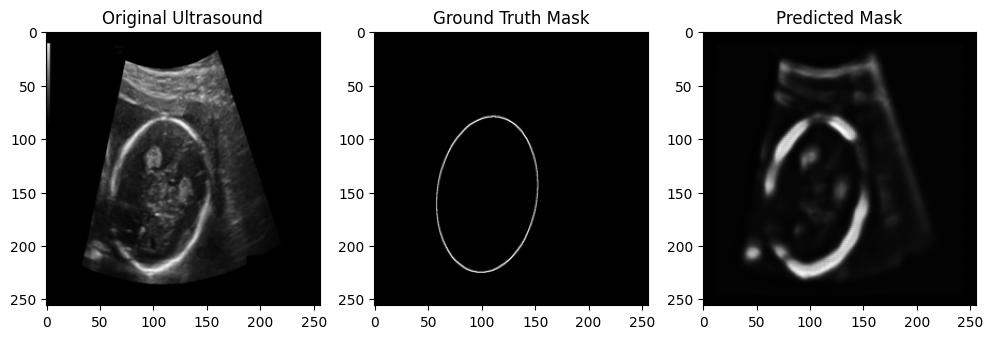

Extracted Ellipse Endpoints: [(196.8603950677164, 143.3453283723375), (45.91317976138515, 138.15680785813126), (117.94635118482519, 240.84207997385036), (124.82722364427637, 40.66005625661839)]
BPD Points (smaller diameter): ((196.8603950677164, 143.3453283723375), (45.91317976138515, 138.15680785813126))
OFD Points (larger diameter): ((117.94635118482519, 240.84207997385036), (124.82722364427637, 40.66005625661839))


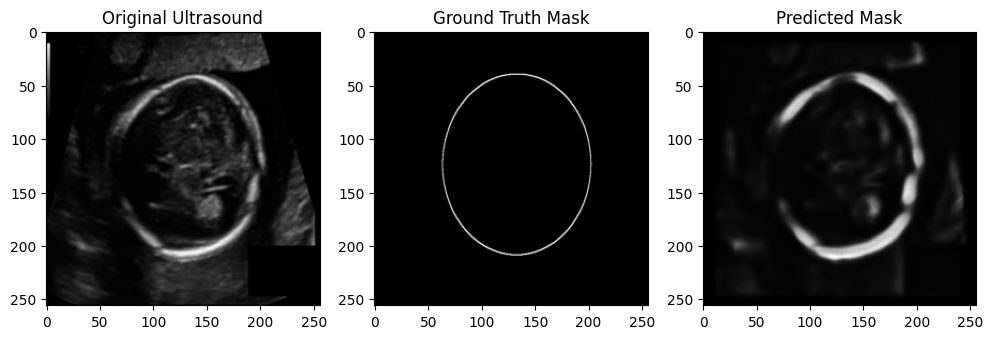

Extracted Ellipse Endpoints: [(72.5760763359445, 142.30853985548808), (201.02331941600863, 124.0425038456838), (123.33463748971049, 38.48886495392121), (150.26475826224262, 227.86217874725065)]
BPD Points (smaller diameter): ((72.5760763359445, 142.30853985548808), (201.02331941600863, 124.0425038456838))
OFD Points (larger diameter): ((123.33463748971049, 38.48886495392121), (150.26475826224262, 227.86217874725065))


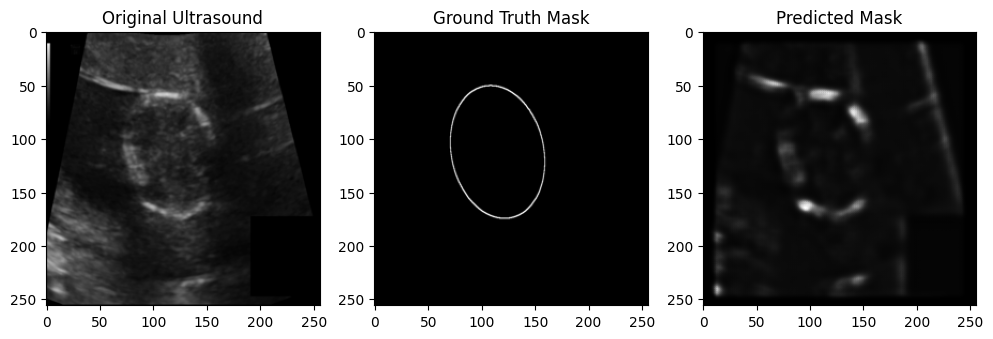

Extracted Ellipse Endpoints: [(66.2412897522281, 195.57998972542916), (5.832204205291436, 194.80840749136772), (35.36715373830622, 247.6183130560458), (36.70634021921331, 142.77008416075108)]
BPD Points (smaller diameter): ((66.2412897522281, 195.57998972542916), (5.832204205291436, 194.80840749136772))
OFD Points (larger diameter): ((35.36715373830622, 247.6183130560458), (36.70634021921331, 142.77008416075108))


In [7]:
# Function to visualize the original image, ground truth mask, and predicted mask
def visualize_results(image_tensor, mask_gt, mask_pred):
    image_np = image_tensor.cpu().permute(1, 2, 0).numpy()  # Convert image tensor to numpy array
    mask_gt_np = mask_gt.squeeze().cpu().numpy()  # Convert ground truth mask to numpy array
    mask_pred_np = mask_pred.squeeze().cpu().numpy()  # Convert predicted mask to numpy array

    plt.figure(figsize=(12, 5))  
    plt.subplot(1, 3, 1)  
    plt.imshow(image_np)  
    plt.title("Original Ultrasound") 

    plt.subplot(1, 3, 2)  
    plt.imshow(mask_gt_np, cmap="gray")  
    plt.title("Ground Truth Mask")  

    plt.subplot(1, 3, 3) 
    plt.imshow(mask_pred_np, cmap="gray")  
    plt.title("Predicted Mask")  

    plt.show()  

sample_images, sample_gt = next(iter(test_loader))
sample_images = sample_images.to(device)
with torch.no_grad():
    sample_preds = model(sample_images)
num_samples_to_visualize = 8
for i in range(min(num_samples_to_visualize, len(sample_images))):
    visualize_results(sample_images[i].cpu(), sample_gt[i], sample_preds[i].cpu())
    # Post-processing: Extract biometry points from the predicted segmentation mask for the sample
    bpd_points, ofd_points, ellipse_pts = extract_skull_diameters(sample_preds[i].cpu())
    print("Extracted Ellipse Endpoints:", ellipse_pts)
    print("BPD Points (smaller diameter):", bpd_points)
    print("OFD Points (larger diameter):", ofd_points)